In [1]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import numpy as np

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pygam import GAM, LinearGAM, PoissonGAM, GammaGAM, s, f, te

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import pickle 
import time
from time import strftime, gmtime
import datetime


## Data Prep

In [2]:
df = pd.read_pickle("2021-tripdata.pkl")

In [3]:
le = LabelEncoder()
col_list = ["rideable_type", "day_of_week"]
for col in col_list:
    df[col] = le.fit_transform(df[col])

In [4]:
X = df.drop(["ride_id", "ride_time"], axis = 1)
y = df["ride_time"]
X.head(10)

,rideable_type,day_of_week,member_casual,seconds_since_midnight,days_since_newyear
0,0,0,False,64560,42
1,0,0,False,39600,42
2,0,0,False,30600,49
3,0,0,True,43620,35
4,0,0,True,61500,35
5,0,0,True,31260,35
6,0,0,True,68460,35
7,0,0,True,27780,49
8,0,0,False,64620,35
9,0,0,False,34800,42


Below we will also transform y to log_y for use on a couple of the models. Note that Poisson data cannot be transformed to Normal so we do not expect this to work.

In [5]:
TRAIN_PERCENTAGE = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = TRAIN_PERCENTAGE,
                                                    random_state = 3)
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

df_train = pd.concat([x_train, y_train], axis = 1)
log_df_train = pd.concat([x_train, log_y_train], axis = 1)

## Model Building

In [6]:
m_list_str = []
m_list = []
time_list = []
MSE_list = []

In [7]:
def get_mse(model, x, y):
    pred = model.predict(x)
    return(metrics.mean_squared_error(y, pred))

def get_mse_log(model, x, y):
    pred = np.exp(model.predict(x))
    return(metrics.mean_squared_error(y, pred))
    
    

In [8]:
def add_model(model, model_name, time_spent, mse):
    m_list.append(model)
    m_list_str.append(model_name)
    time_list.append(time_spent)
    MSE_list.append(mse)
    
    

In [9]:
t0 = time.time()
lm = smf.ols("ride_time ~ rideable_type + day_of_week + member_casual + seconds_since_midnight + days_since_newyear", 
             df_train).fit()
t1 = time.time()
add_model(lm, "lm", t1 - t0, get_mse(lm, x_test, y_test))

In [10]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ride_time   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     8501.
Date:                Sun, 20 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:31:46   Log-Likelihood:            -1.0312e+07
No. Observations:             1128805   AIC:                         2.062e+07
Df Residuals:                 1128799   BIC:                         2.062e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2014.4429      9.628    209.228      0.000    1995.572    2033.313
member_casual[T.True]   -834.4240      4.284   -194.774      0.000    -842.821    -826.027
rideable_type            -76.2245      2.260    -33.723      0.000     -80.655     -71.794
day_of_week              -18.5269      1.079    -17.163      0.000     -20.643     -16.411
seconds_since_midnight     0.0003      0.000      2.226      0.026     3.1e-05       0.000
days_since_newyear        -1.3399      0.028    -48.388      0.000      -1.394      -1.286
==============================================================================
Omnibus:                  2336823.178   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      10513256564.420
Skew:                          17.685   Prob(JB):                         0.00
Kurtosis:                     474.461   Cond. No.                     2.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
t0 = time.time()
log_lm = smf.ols("ride_time ~ rideable_type + day_of_week + member_casual + seconds_since_midnight + days_since_newyear", 
             log_df_train).fit()
t1 = time.time()

add_model(log_lm, "log_lm", t1 - t0, get_mse_log(log_lm, x_test, y_test))


In [12]:
log_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ride_time   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                 2.225e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:31:47   Log-Likelihood:            -1.5430e+06
No. Observations:             1128805   AIC:                         3.086e+06
Df Residuals:                 1128799   BIC:                         3.086e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.1178      0.004   1748.477      0.000       7.110       7.126
member_casual[T.True]     -0.5609      0.002   -309.676      0.000      -0.564      -0.557
rideable_type             -0.0680      0.001    -71.124      0.000      -0.070      -0.066
day_of_week               -0.0121      0.000    -26.611      0.000      -0.013      -0.011
seconds_since_midnight  1.023e-06   4.93e-08     20.760      0.000    9.27e-07    1.12e-06
days_since_newyear        -0.0010   1.17e-05    -83.459      0.000      -0.001      -0.001
==============================================================================
Omnibus:                   197874.493   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           956684.824
Skew:                          -0.776   Prob(JB):                         0.00
Kurtosis:                       7.234   Cond. No.                     2.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
t0 = time.time()
lin_gam = LinearGAM(f(0) + f(1) + f(2) + s(3) + s(4)).fit(x_train, y_train)
t1 = time.time()

add_model(lin_gam, "lin_gam", t1 - t0, get_mse(lin_gam, x_test, y_test))

In [14]:

lin_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6974
Link Function:                     IdentityLink Log Likelihood:                             -18421449.7985
Number of Samples:                      1128805 AIC:                                         36842996.9917
                                                AICc:                                         36842996.996
                                                GCV:                                          4879549.9145
                                                Scale:                                        4879178.7841
                                                Pseudo R-Squared:                                   0.0673
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/4122837984.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  lin_gam.summary()


In [15]:
t0 = time.time()
log_lin_gam = LinearGAM(f(0) + f(1) + f(2) + s(3) + s(4)).fit(x_train, log_y_train)
t1 = time.time()

add_model(log_lin_gam, "log_lin_gam", t1 - t0, get_mse_log(log_lin_gam, x_test, y_test))

In [16]:
log_lin_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6974
Link Function:                     IdentityLink Log Likelihood:                              -1526829.2238
Number of Samples:                      1128805 AIC:                                          3053755.8424
                                                AICc:                                         3053755.8466
                                                GCV:                                                0.8665
                                                Scale:                                              0.8664
                                                Pseudo R-Squared:                                    0.125
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/3368164684.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  log_lin_gam.summary()


In [17]:
t0 = time.time()
poisson_gam = GAM(f(0) + f(1) + f(2) + s(3) + s(4), 
                  distribution = "poisson",
                  max_iter = 250).fit(x_train, y_train)
t1 = time.time()

add_model(poisson_gam, "poisson_gam", t1 - t0, get_mse(poisson_gam, x_test, y_test))

In [18]:
poisson_gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     35.8965
Link Function:                     IdentityLink Log Likelihood:                            -643406686.3659
Number of Samples:                      1128805 AIC:                                       1286813444.5249
                                                AICc:                                      1286813444.5273
                                                UBRE:                                            1133.5675
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1762
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/2612922839.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  poisson_gam.summary()


In [19]:
t0 = time.time()
gamma_log_gam = GAM(f(0) + f(1) + f(2) + s(3) + s(4), 
                             distribution = "gamma",
                            link = "log").fit(x_train, y_train)
#gamma_log_gam = GammaGAM(f(0) + f(1) + f(2) + s(3) + s(4)).fit(x_train, y_train)
t1 = time.time()

add_model(gamma_log_gam, "gamma_log_gam", t1 - t0, get_mse(gamma_log_gam, x_test, y_test))

In [20]:
gamma_log_gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     47.6974
Link Function:                          LogLink Log Likelihood:                              -9346740.0727
Number of Samples:                      1128805 AIC:                                         18693577.5402
                                                AICc:                                        18693577.5445
                                                GCV:                                                0.8106
                                                Scale:                                              2.4115
                                                Pseudo R-Squared:                                   0.1879
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/3240312660.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gamma_log_gam.summary()


In [21]:
t0 = time.time()
poisson_log_gam = GAM(f(0) + f(1) + f(2) + s(3) + s(4), 
                             distribution = "poisson",
                            link = "log",
                             max_iter = 250).fit(x_train, y_train)
t1 = time.time()

add_model(poisson_log_gam, "poisson_log_gam", t1 - t0, get_mse(poisson_log_gam, x_test, y_test))

did not converge


In [22]:
poisson_log_gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     47.9997
Link Function:                          LogLink Log Likelihood:                            -639890718.0445
Number of Samples:                      1128805 AIC:                                       1279781532.0883
                                                AICc:                                      1279781532.0926
                                                UBRE:                                             1127.338
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1807
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/3419979841.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  poisson_log_gam.summary()


## Model Evaluation

In [23]:
# # m_list_str = ["lm", "lin_gam", "poisson_gam", "poisson_log_gam"]
# # m_list = [lm, lin_gam, poisson_gam, poisson_log_gam]

# for i in range(len(m_list)):
#     this_mse = get_mse(m_list[i], x_test, y_test)
#     MSE_list.append(this_mse)
#     print(f"{m_list_str[i]}\nmse = {int(this_mse):,}\n")

In [24]:
def save_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)
        
def load_model(filename):
    with open(filename, "rb") as f:
        model = pickle.load(f)
        
def save_all_models(m_list, m_list_str):
    f_list = ["saved_models/" + item + ".pkl" for item in m_list_str]

    for i in range(len(m_list)):
        save_model(m_list[i], f_list[i])

In [25]:
save_all_models(m_list, m_list_str)

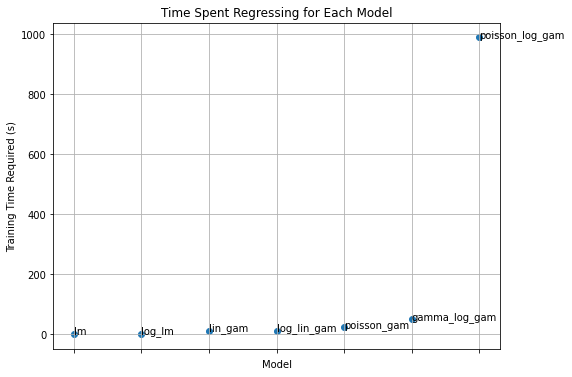

In [26]:

x_axis = np.arange(len(time_list))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_xticklabels([])
ax.set_ylabel("Training Time Required (s)")
ax.set_xlabel("Model")
ax.set_title("Time Spent Regressing for Each Model")
plt.scatter(x_axis, time_list)

for i in range(len(x_axis)):
    ax.annotate("%s" % m_list_str[i],xy = (x_axis[i], time_list[i]), textcoords = "data")
plt.show()

In [27]:

def plot_mse_for_models(MSE_list, m_list_str):
    x_axis = np.arange(len(m_list_str))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Model")
    ax.set_title("MSE for Each Model")
    plt.scatter(x_axis, MSE_list)

    for i in range(len(x_axis)):
        ax.annotate("%s" % m_list_str[i],xy = (x_axis[i], MSE_list[i]), textcoords = "data")
    plt.show()

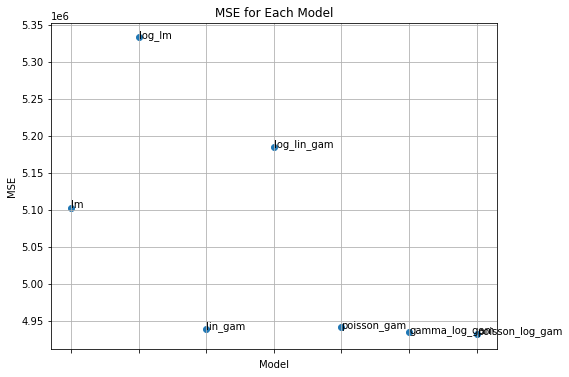

In [28]:
plot_mse_for_models(MSE_list, m_list_str)

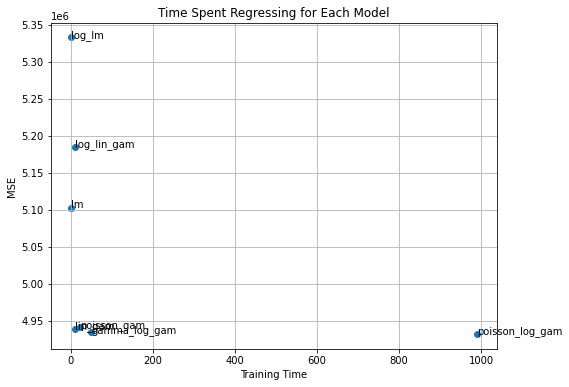

In [29]:



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_ylabel("MSE")
ax.set_xlabel("Training Time")
ax.set_title("Time Spent Regressing for Each Model")
plt.scatter(time_list, MSE_list)

for i in range(len(time_list)):
    ax.annotate("%s" % m_list_str[i],xy = (time_list[i], MSE_list[i]), textcoords = "data")
plt.show()

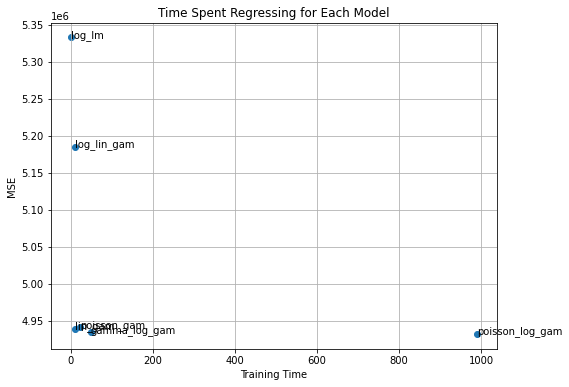

In [30]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_ylabel("MSE")
ax.set_xlabel("Training Time")
ax.set_title("Time Spent Regressing for Each Model")
plt.scatter(time_list[1:], MSE_list[1:])

for i in range(1, len(time_list)):
    ax.annotate("%s" % m_list_str[i],xy = (time_list[i], MSE_list[i]), textcoords = "data")
plt.show()

## Poisson GAM with Log link

Now we further explore the best performing model. Due to the fact that this model has high training time we will reduce our training dataset size by a factor of 10.

*Stepwise Model Comparison*
We test removal of predictors as well as interaction effects.

In [31]:
TRAIN_PERCENTAGE = 0.1 * TRAIN_PERCENTAGE # only use 10% the training data to speed up comparison
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = TRAIN_PERCENTAGE,
                                                   random_state = 3)

In [32]:
m_list = []
m_list_string = []
MSE_list = []

In [33]:
full_model = GAM(f(0) + f(1) + f(2) + s(3) + s(4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(full_model)
m_list_string.append("full_model")

did not converge


In [34]:
no_type = GAM(f(1) + f(2) + s(3) + s(4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(no_type)
m_list_string.append("no_type")

did not converge


In [35]:
no_day = GAM(f(0) + f(2) + s(3) + s(4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(no_day)
m_list_string.append("no_day")

did not converge


In [36]:
no_member = GAM(f(0) + f(1) + s(3) + s(4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(no_member)
m_list_string.append("no_member")

did not converge


In [37]:
no_seconds = GAM(f(0) + f(1) + f(2) + s(4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(no_seconds)
m_list_string.append("no_seconds")

did not converge


In [38]:
no_days = GAM(f(0) + f(1) + f(2) + s(3), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(no_days)
m_list_string.append("no_days")

In [39]:
full_with_interaction = GAM(f(0) + f(1) + f(2) + s(3) + s(4) + te(3,4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(full_with_interaction)
m_list_string.append("full_with_interaction")

In [40]:
full_with_interaction_2 = GAM(f(0) + f(1) + f(2) + s(3) + s(4) + te(1,4), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(full_with_interaction_2)
m_list_string.append("full_with_interaction_2")

In [41]:
full_with_interaction_3 = GAM(f(0) + f(1) + f(2) + s(3) + s(4) + te(0,2), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(full_with_interaction_3)
m_list_string.append("full_with_interaction_3")

did not converge


In [42]:
full_with_interaction_4 = GAM(f(0) + f(1) + f(2) + s(3) + s(4) + te(1,3), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=200).fit(x_train, y_train)
m_list.append(full_with_interaction_4)
m_list_string.append("full_with_interaction_4")

did not converge


In [43]:
for i in range(len(m_list)):
    this_mse = get_mse(m_list[i], x_test, y_test)
    MSE_list.append(this_mse)
    print(f"{m_list_string[i]}\nmse = {int(this_mse):,}\n")

full_model
mse = 4,916,608

no_type
mse = 5,059,143

no_day
mse = 4,922,842

no_member
mse = 4,995,994

no_seconds
mse = 4,918,967

no_days
mse = 4,928,532

full_with_interaction
mse = 4,920,803

full_with_interaction_2
mse = 4,918,462

full_with_interaction_3
mse = 4,914,206

full_with_interaction_4
mse = 4,919,568



In [44]:
save_all_models(m_list, m_list_string)

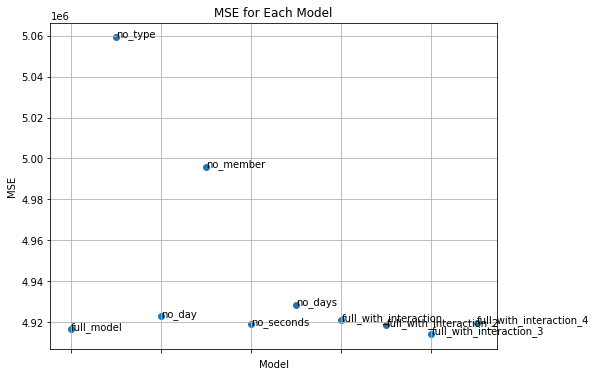

In [45]:
plot_mse_for_models(MSE_list, m_list_string)

## Final Model and Interpretation

In [62]:
TRAIN_PERCENTAGE = 0.4 # same as initial train percentage. 
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = TRAIN_PERCENTAGE,
                                                    random_state = 3)

In [63]:
best_m = GAM(f(0) + f(1) + f(2) + s(3) + s(4) + te(0,2), 
                             distribution = "poisson",
                            link = "log",
                            max_iter=500).fit(x_train, y_train)


did not converge


In [64]:
best_m.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     49.9985
Link Function:                          LogLink Log Likelihood:                            -1287327681.768
Number of Samples:                      2257611 AIC:                                       2574655463.5332
                                                AICc:                                      2574655463.5355
                                                UBRE:                                            1134.0226
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1807
Feature Function                  Lam

/var/folders/lp/cgkjbm6d28q33c7wy798m6h00000gn/T/ipykernel_61463/4009236369.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  best_m.summary()


We should check that a larger training sample is not leading to overfitting

In [79]:
mse_best = get_mse(best_m, x_test, y_test)
mse_og = get_mse(poisson_log_gam, x_test, y_test)


print(f"testing MSE for best poisson log gam:\n{mse_best}\n")
print(f"testing MSE for original poisson log gam:\n{mse_og}\n")
print(f"percent improvement: {-N100 * (mse_best - mse_og)/mse_og}")

testing MSE for best poisson log gam:
4891379.565112801

testing MSE for original poisson log gam:
4893926.787743876

percent improvement: 0.05204864603724017


### Plotting

First we will plot the coefficients vs predictor to learn from the model what it sees in the data.

In [66]:
%matplotlib inline

In [67]:
def plot_pygam_term(model, i, title):
    
    plt.figure()
    fig, ax = plt.subplots()
    XX = model.generate_X_grid(term=i)
    ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX), c='k', ls='dashdot')
    #ax.plot(XX[:, i], model.partial_dependence(term=i, X=XX, width=.1)[1], c='r', ls='--')
    ax.set_title(title);
    plt.show()

In [68]:
def plot_pygam(model, title_list):
    for i, title in enumerate(title_list):
        plot_pygam_term(model, i, title)

<Figure size 432x288 with 0 Axes>

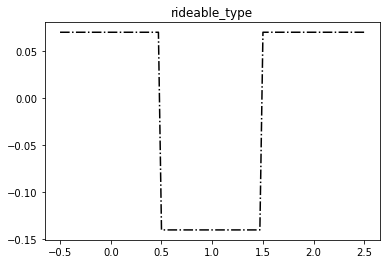

<Figure size 432x288 with 0 Axes>

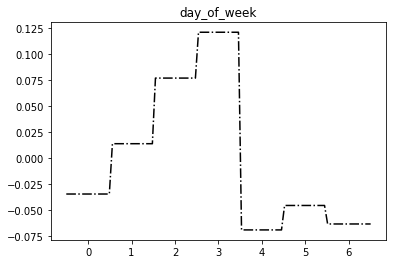

<Figure size 432x288 with 0 Axes>

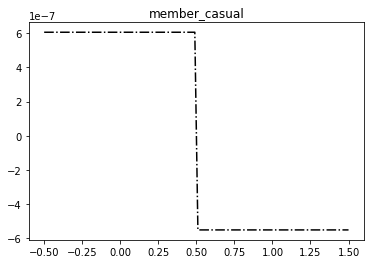

<Figure size 432x288 with 0 Axes>

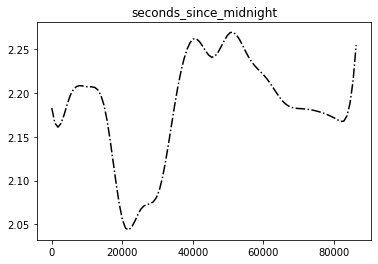

<Figure size 432x288 with 0 Axes>

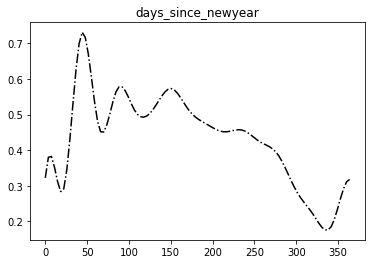

In [69]:
titles = ['rideable_type', 'day_of_week', 'member_casual', 'seconds_since_midnight', 'days_since_newyear']
plot_pygam(best_m, titles)

## Better Plotting

Now let's fix the plots for our two datetime predictors so that they're more interpretable

In [70]:
def seconds_to_time(seconds):
    return(strftime("%H:%M:%S", gmtime(seconds)))
seconds_to_time_v = np.vectorize(seconds_to_time)

In [71]:
XX = best_m.generate_X_grid(term=3)
x_axis = XX[:, 3]
x_axis = seconds_to_time_v(x_axis)

<Figure size 1152x576 with 0 Axes>

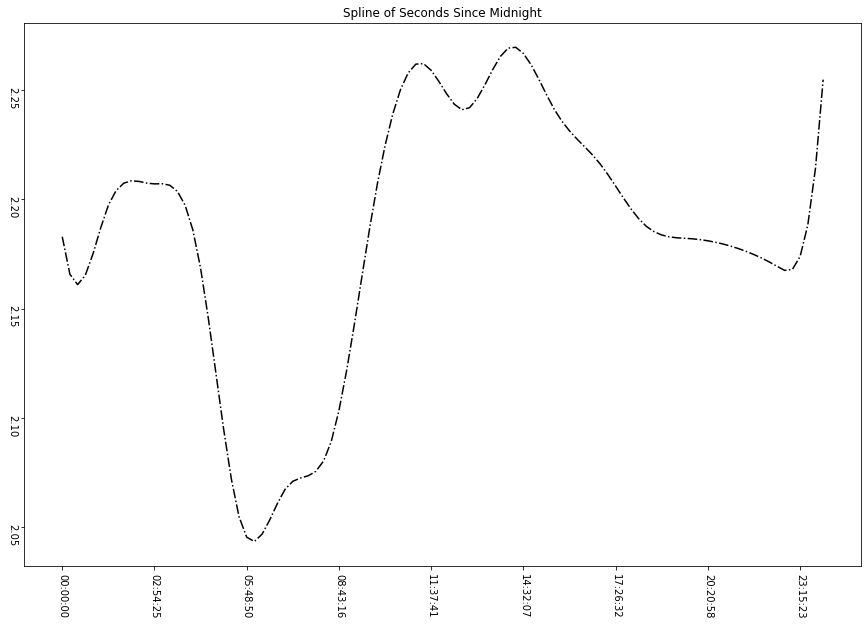

In [72]:
plt.figure(figsize = (16,8))
fig, ax = plt.subplots()
XX = best_m.generate_X_grid(term=3)
ax.plot(x_axis, best_m.partial_dependence(term=3, X=XX), c='k', ls='dashdot')


original_ticks = ax.get_xticks()
ticks = []
for i in range(len(original_ticks)):
    if i%12 == 0:
        ticks.append(original_ticks[i])
ax.set_xticks(ticks)
ax.tick_params(labelrotation = -90)
ax.set_title("Spline of Seconds Since Midnight")
plt.gcf().set_size_inches(15, 10)
plt.show()

In [73]:
def days_to_date(days):
    start = datetime.datetime(2021,1,1)
    return(start + datetime.timedelta(days = days))
days_to_date_v = np.vectorize(days_to_date)

In [74]:
XX = best_m.generate_X_grid(term=4, n = 100)
x_axis = XX[:, 4]
x_axis = days_to_date_v(x_axis)

<Figure size 1152x576 with 0 Axes>

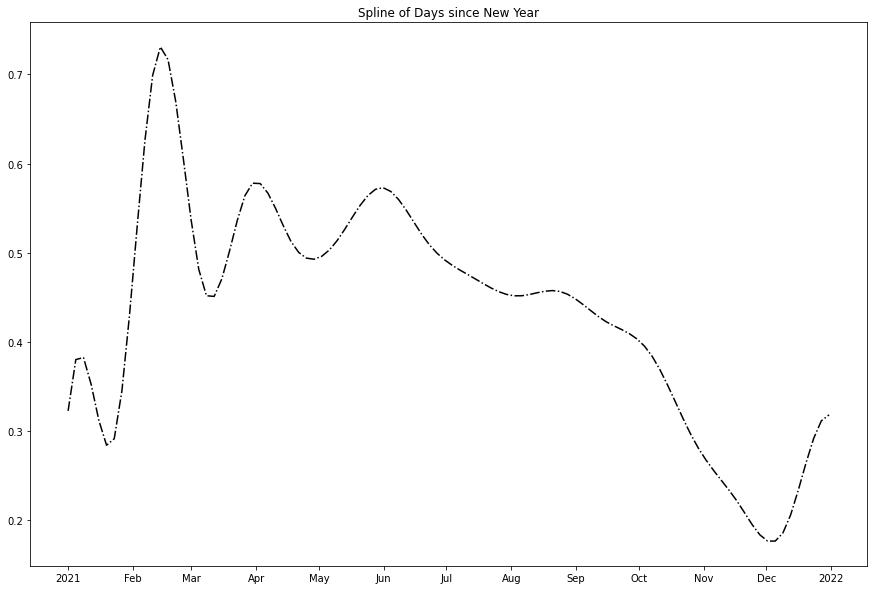

In [75]:
import matplotlib.dates as mdates

plt.figure(figsize = (16,8))
fig, ax = plt.subplots()
XX = best_m.generate_X_grid(term=4)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))


ax.plot(x_axis, best_m.partial_dependence(term=4, X=XX), c='k', ls='dashdot')


# original_ticks = ax.get_xticks()
# print(original_ticks)
# ticks = []
# for i in range(len(original_ticks)):
#     if i%2 == 0:
#         ticks.append(original_ticks[i])
# ax.set_xticks(original_ticks)
# ax.tick_params(labelrotation = -90)
ax.set_title("Spline of Days since New Year")
plt.gcf().set_size_inches(15, 10)
plt.show()

### Interaction Effect

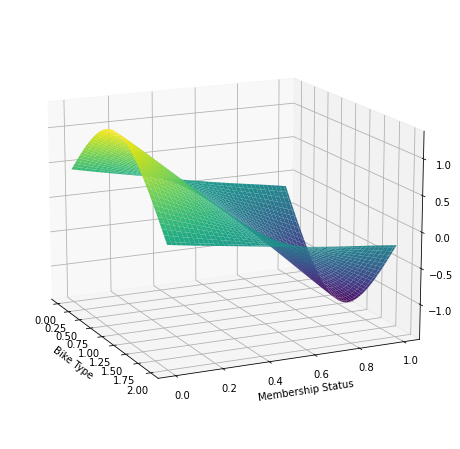

In [76]:
plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)

XX = best_m.generate_X_grid(term=5, meshgrid=True)
Z = best_m.partial_dependence(term=5, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.set_xlabel("Bike Type")
ax.set_ylabel("Membership Status")
ax.view_init(15, -25)
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

0 corresponds to classic bike

1 corresponds to docked bike

2 corresponds to electric bike

In [77]:
save_model(best_m, "best_m.pkl")